In [1]:
#Plot of confirmed Corona cases in selected countries.
#Last update: 2020-03-28, 10:00, JL

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sta
import scipy.optimize
import statsmodels.stats.api as sms

#https://github.com/CSSEGISandData/COVID-19
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
#fn_confirmed='time_series_19-covid-Confirmed.csv' # deprecated 3/23/2020
fn_confirmed='time_series_covid19_confirmed_global.csv'
#fn_deaths='time_series_19-covid-Deaths.csv'
fn_deaths='time_series_covid19_deaths_global.csv'
#fn_recovered='time_series_19-covid-Recovered.csv'
fn_recovered='time_series_covid19_recovered_global.csv'
fn_population='https://raw.githubusercontent.com/datasets/population/master/data/population.csv'
fn_rkiData='https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv'

In [2]:
df_rki=pd.read_csv(fn_rkiData,index_col=None)
df_rki.Meldedatum=pd.to_datetime(df_rki.Meldedatum)

df_rki.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall
0,3,Niedersachsen,LK Goslar,A60-A79,M,2,0,444297,2020-03-13,3153,28.03.2020 00:00,0,-9
1,3,Niedersachsen,LK Goslar,A60-A79,M,1,0,444298,2020-03-18,3153,28.03.2020 00:00,0,-9
2,3,Niedersachsen,LK Goslar,A60-A79,M,1,0,444299,2020-03-23,3153,28.03.2020 00:00,0,-9
3,3,Niedersachsen,LK Goslar,A60-A79,M,1,0,444300,2020-03-24,3153,28.03.2020 00:00,0,-9
4,3,Niedersachsen,LK Goslar,A60-A79,M,1,0,444301,2020-03-25,3153,28.03.2020 00:00,0,-9


In [3]:
# get John's Hopkins data and consolidate for countries.
def getJHUdata(fn,valName='cases'):
    df = pd.read_csv(fn,index_col=None)
    df=df.drop(['Lat','Long'],axis=1)
    df=df.set_index([*df.columns[:2]])
    df=df.stack().reset_index()
    df.columns=['state','country','date',valName]
    df.date=pd.to_datetime(df.date)
    df=df.groupby(['country','date']).sum().reset_index()
    return df

In [4]:
dfc = getJHUdata(url+fn_confirmed)
dfc.tail()

,country,date,cases
11611,Zimbabwe,2020-03-23,3
11612,Zimbabwe,2020-03-24,3
11613,Zimbabwe,2020-03-25,3
11614,Zimbabwe,2020-03-26,3
11615,Zimbabwe,2020-03-27,5


In [5]:
dfd = getJHUdata(url+fn_deaths,'deaths')
dfd.tail()

,country,date,deaths
11611,Zimbabwe,2020-03-23,1
11612,Zimbabwe,2020-03-24,1
11613,Zimbabwe,2020-03-25,1
11614,Zimbabwe,2020-03-26,1
11615,Zimbabwe,2020-03-27,1


In [6]:
dfr = getJHUdata(url+fn_recovered,'recovered')
dfr.tail()

,country,date,recovered
11611,Zimbabwe,2020-03-23,0
11612,Zimbabwe,2020-03-24,0
11613,Zimbabwe,2020-03-25,0
11614,Zimbabwe,2020-03-26,0
11615,Zimbabwe,2020-03-27,0


In [7]:
# get population data.
# Note, many country names don't match between population and case data.
dfp = pd.read_csv(fn_population)
dfp=dfp[dfp.Year==dfp.Year.max()]
dfp.columns=[*dfp.columns[:-1],'population']
dfp.head()

,Country Name,Country Code,Year,population
56,Arab World,ARB,2016,4.064527e+08
113,Caribbean small states,CSS,2016,7.245472e+06
170,Central Europe and the Baltics,CEB,2016,1.029741e+08
227,Early-demographic dividend,EAR,2016,3.170542e+09
284,East Asia & Pacific,EAS,2016,2.296786e+09


In [8]:
df=dfc.merge(dfd,on=[*dfc.columns[:2]])
df=df.merge(dfr,on=[*dfc.columns[:2]])
df=df.merge(dfp[[dfp.columns[0],'population']],how='left',left_on='country',right_on=dfp.columns[0])
df=df.drop('Country Name',axis=1)
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,country,date,cases,deaths,recovered,population
0,Afghanistan,2020-01-22,0,0,0,34656032.0
1,Afghanistan,2020-01-23,0,0,0,34656032.0
2,Afghanistan,2020-01-24,0,0,0,34656032.0
3,Afghanistan,2020-01-25,0,0,0,34656032.0
4,Afghanistan,2020-01-26,0,0,0,34656032.0


In [9]:
# Compute ratios
df['cdRatio']=df.deaths/df.cases
df['casePerPop']=df.cases/df.population
df['activeCases']=df.cases-df.deaths-df.recovered
df['crRatio']=df.recovered/df.cases

df['newCases']=df.groupby(['country']).diff().cases

In [10]:
# Show all country names in the case data
allCountries=sorted(df.country.unique())
for a,b,c in zip(allCountries[::3],allCountries[1::3],allCountries[2::3]):
    print('{:<30}{:<30}{:<}'.format(a,b,c))

Afghanistan                   Albania                       Algeria
Andorra                       Angola                        Antigua and Barbuda
Argentina                     Armenia                       Australia
Austria                       Azerbaijan                    Bahamas
Bahrain                       Bangladesh                    Barbados
Belarus                       Belgium                       Belize
Benin                         Bhutan                        Bolivia
Bosnia and Herzegovina        Brazil                        Brunei
Bulgaria                      Burkina Faso                  Burma
Cabo Verde                    Cambodia                      Cameroon
Canada                        Central African Republic      Chad
Chile                         China                         Colombia
Congo (Brazzaville)           Congo (Kinshasa)              Costa Rica
Cote d'Ivoire                 Croatia                       Cuba
Cyprus                        Czechia 

In [11]:
# Select countries for plots.
plotCountries=['Germany','Italy','Spain','France','Portugal', 'Korea, South','US','China']
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')

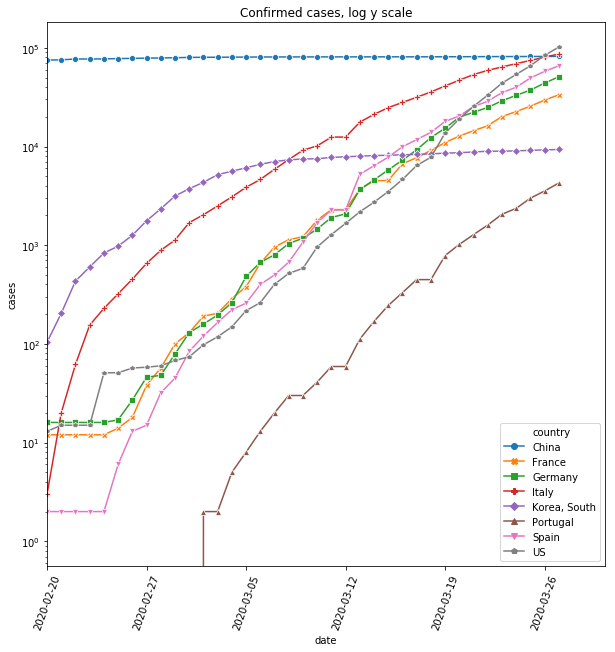

In [12]:
# Plot cases on log y scale
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)
ax = g.axes
ax.set_yscale('log')
plt.title('Confirmed cases, log y scale')
plt.xlim(left=plotStartDate)
plt.xticks(rotation=70);

Note similar slopes of european countries. Italy took of earlier

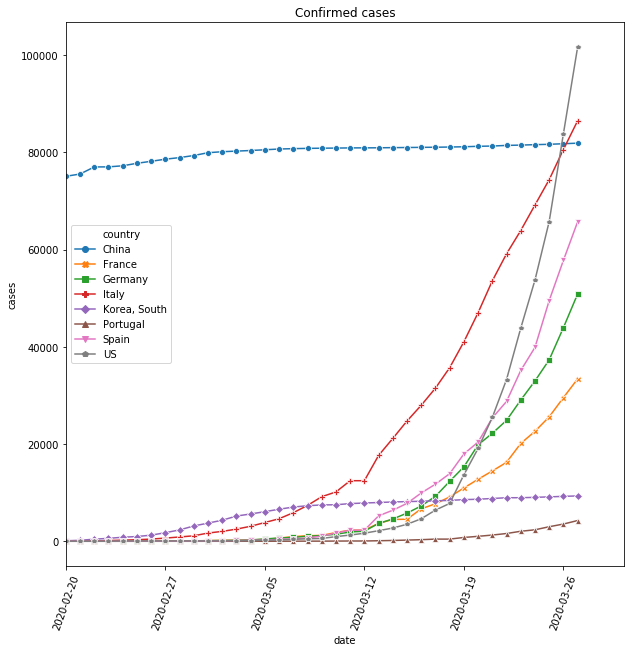

In [13]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.title('Confirmed cases');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

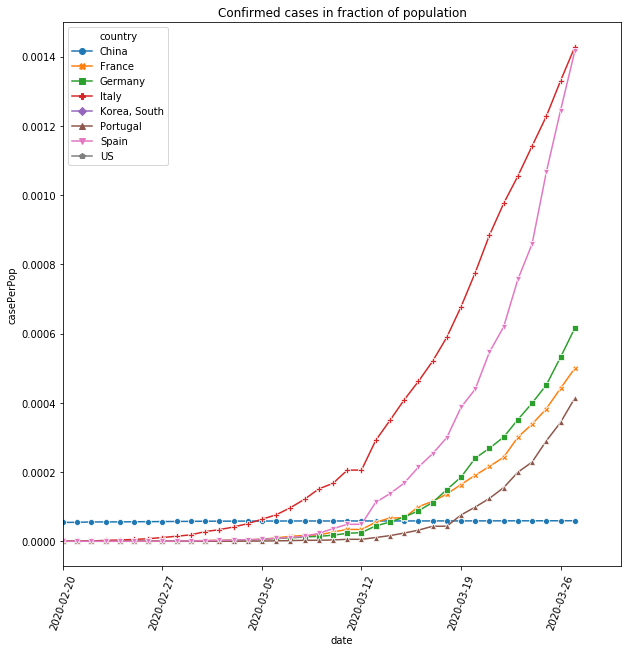

In [14]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='casePerPop',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.title('Confirmed cases in fraction of population');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

# New cases over time: Have any countries flattened the curve?
inspired by a NYT article -
https://www.nytimes.com/interactive/2020/03/19/world/coronavirus-flatten-the-curve-countries.html

Singapore, Taiwan, Japan, Thailand slowed the onset of exponential growth. South Korea and China managed to reduce new cases greatly.

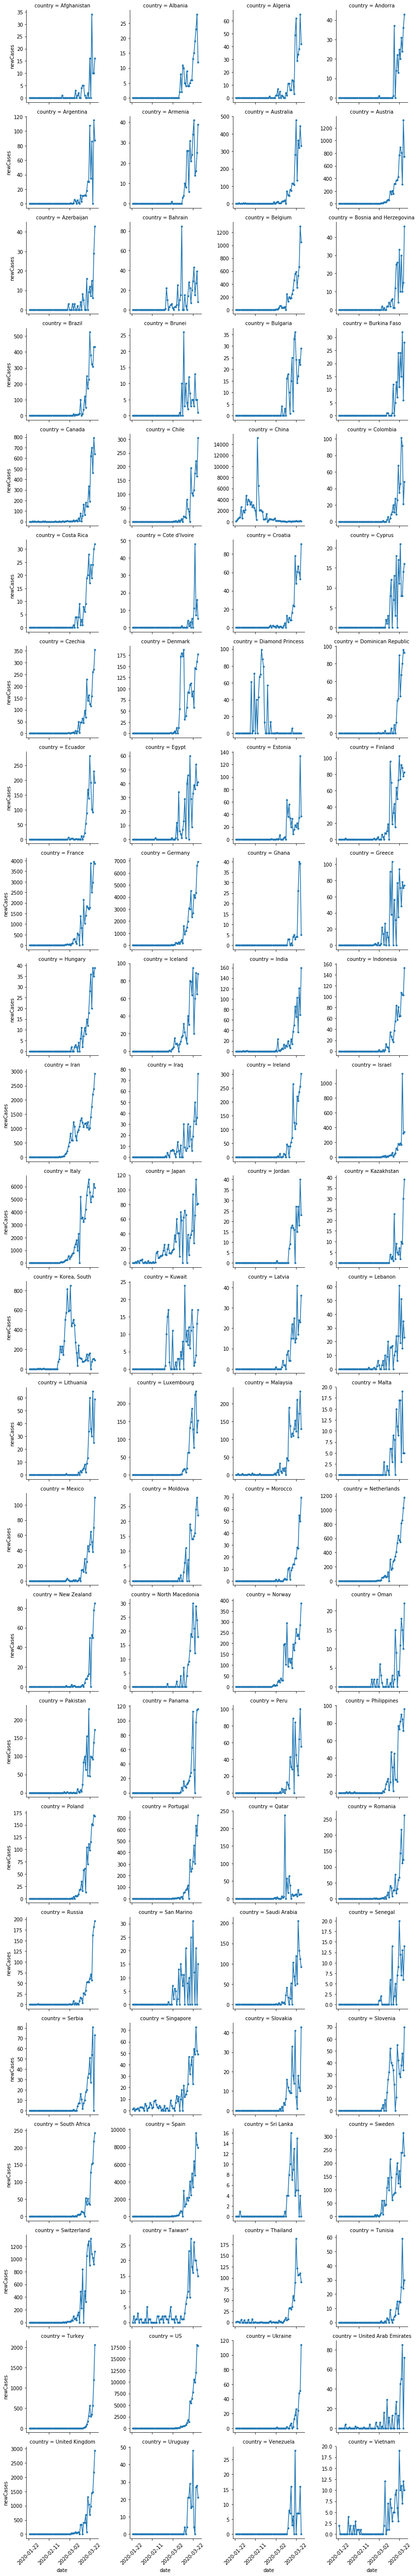

In [15]:
HighCountries=df[df.cases>100].country.unique()
ix=df.country.isin(HighCountries)

g = sns.FacetGrid(df[ix], col="country",  palette="tab20c",
                     col_wrap=4, height=3,sharey=False)

g.map(plt.plot, "date", "newCases",marker='.')

g.set(xticks=df.date.unique()[::20], xticklabels=df.date.unique()[::20])
g.set_xticklabels(rotation=45);



In [16]:
# Show latest data for Germany
ix=df.country.isin(['Germany'])
df.loc[ix][-3:]

,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases
4221,Germany,2020-03-25,37323,206,3547,82667685.0,0.005519,0.000451,33570,0.095035,4337.0
4222,Germany,2020-03-26,43938,267,5673,82667685.0,0.006077,0.000532,37998,0.129114,6615.0
4223,Germany,2020-03-27,50871,342,6658,82667685.0,0.006723,0.000615,43871,0.130880,6933.0


In [17]:
# Show latest data for US

ix=df.country.isin(['US'])
df.loc[ix][-3:]

,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases
10887,US,2020-03-25,65778,942,361,NaN,0.014321,NaN,64475,0.005488,12038.0
10888,US,2020-03-26,83836,1209,681,NaN,0.014421,NaN,81946,0.008123,18058.0
10889,US,2020-03-27,101657,1581,869,NaN,0.015552,NaN,99207,0.008548,17821.0


# Plot cases aligned to date of crossing 100 cases

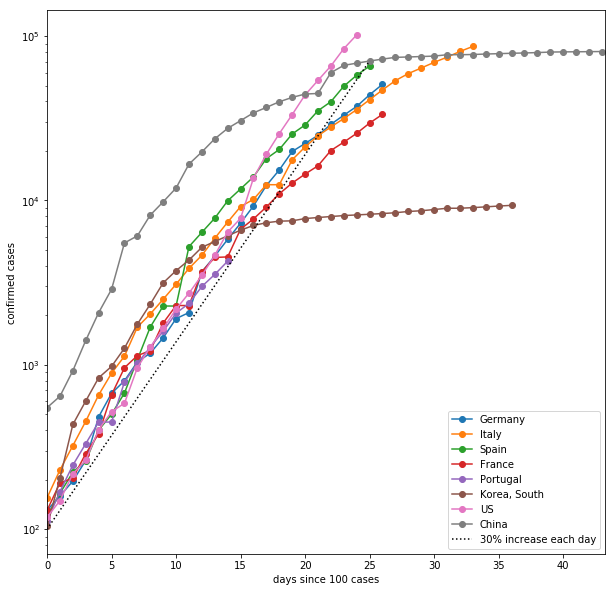

In [18]:
fix,ax=plt.subplots(figsize=(10,10))


for i,c in enumerate(plotCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        inflect=np.argmax(ts>100)
        ax.plot(ts[inflect:],'o-',label=c)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
ul=ax.get_xlim()[1]
ax.set_xlim([0,ul-25])
plt.legend()
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

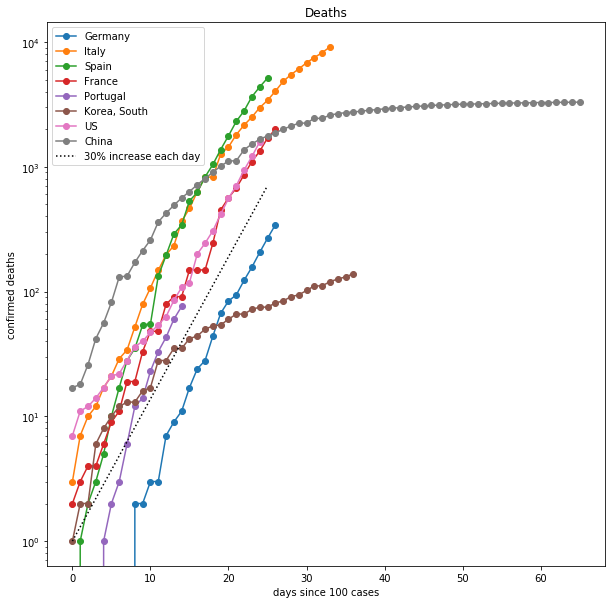

In [19]:
fix,ax=plt.subplots(figsize=(10,10))


for i,c in enumerate(plotCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        inflect=np.argmax(ts>100)
        tsDeaths=df[ix].deaths.values
        ax.plot(tsDeaths[inflect:],'o-',label=c)
    
t=np.linspace(0,25,100)
e=1*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend()
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed deaths')
plt.title('Deaths');

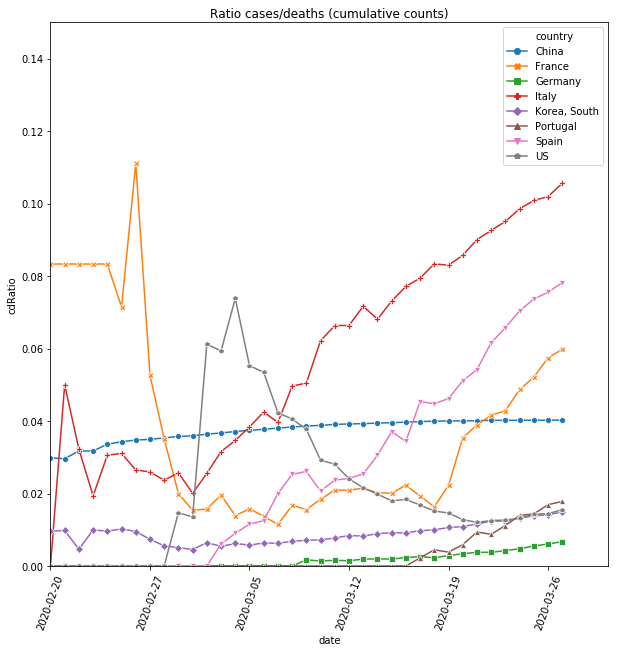

In [20]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cdRatio',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
plt.ylim([0,.15])
plt.title('Ratio cases/deaths (cumulative counts)')
plt.xlim(left=plotStartDate);

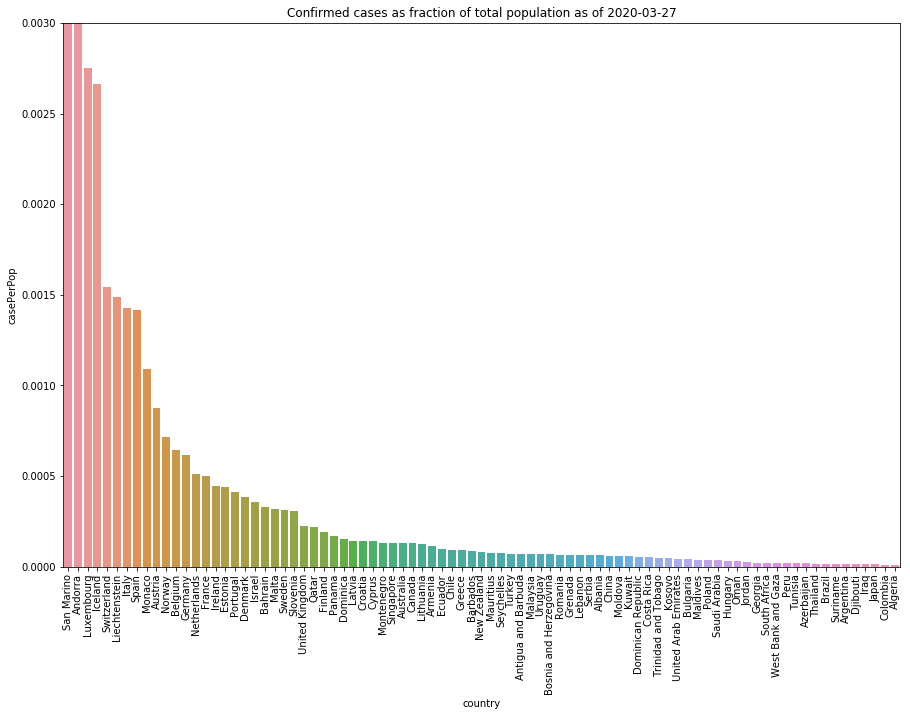

In [21]:
plt.subplots(figsize=(15,10))
ix=(df.date==df.date.max())&(df.casePerPop>0.00001)
sns.barplot(data=df[ix].sort_values(by=['casePerPop'],ascending=False),
            x='country',y='casePerPop')
plt.ylim([0,.003])
plt.title('Confirmed cases as fraction of total population as of '+str(df.date.max()))
plt.xticks(rotation=90);

#  Find % increase per day per country for recent history
## testing only countries with > 250 cases

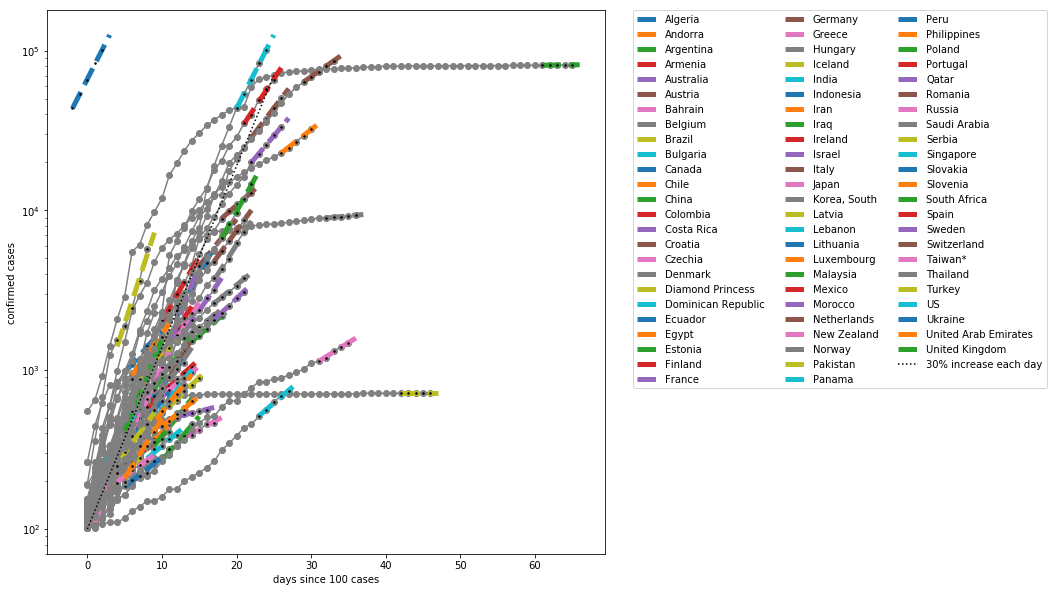

In [22]:
fitHistory=5 #days used for fit

fix,ax=plt.subplots(figsize=(10,10))

HighCountries=df[df.cases>250].country.unique()

allSlopes=np.zeros((len(HighCountries),100))*np.nan

for i,c in enumerate(HighCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        caseLen=ts.shape[0]
        inflect=np.argmax(ts>100)
        
        for j in range(ts.shape[0]-fitHistory-inflect):
            x=np.arange(fitHistory)
            y=np.log10(ts[j+inflect+1:j+fitHistory+inflect+1])

            s,itc,r,p,std=scipy.stats.linregress(x,y)
            allSlopes[i,j+inflect+1]=s
        
        ax.plot(ts[inflect:],'o-',color='gray')
        t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
        tx=np.linspace(0,fitHistory,100)
        l=(10**itc)*(10**(s*tx))
        ax.plot(t,l,'--',label=c,lw=5)
        ax.plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend(ncol=3,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

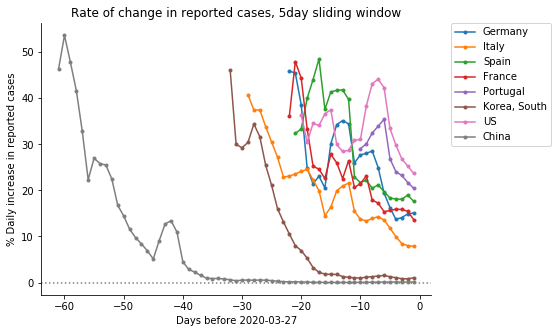

In [23]:
fix,ax=plt.subplots(figsize=(7,5))

today=np.where(np.nansum(allSlopes,axis=0)==0)[0][1]
xt=np.arange(allSlopes.shape[1])-today
for i,c in enumerate(plotCountries):
    ic=np.where(HighCountries==c)[0][0]
    ax.plot(xt,100*(10**allSlopes[ic,:]-1),'.-',label=c);
    #ax.set_xlim([40,70]);
    
plt.legend()
plt.axhline(0,ls=':',color='gray')
plt.ylabel('% Daily increase in reported cases')
plt.xlabel('Days before '+ str(df.date.max()));
plt.title('Rate of change in reported cases, 5day sliding window')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine()

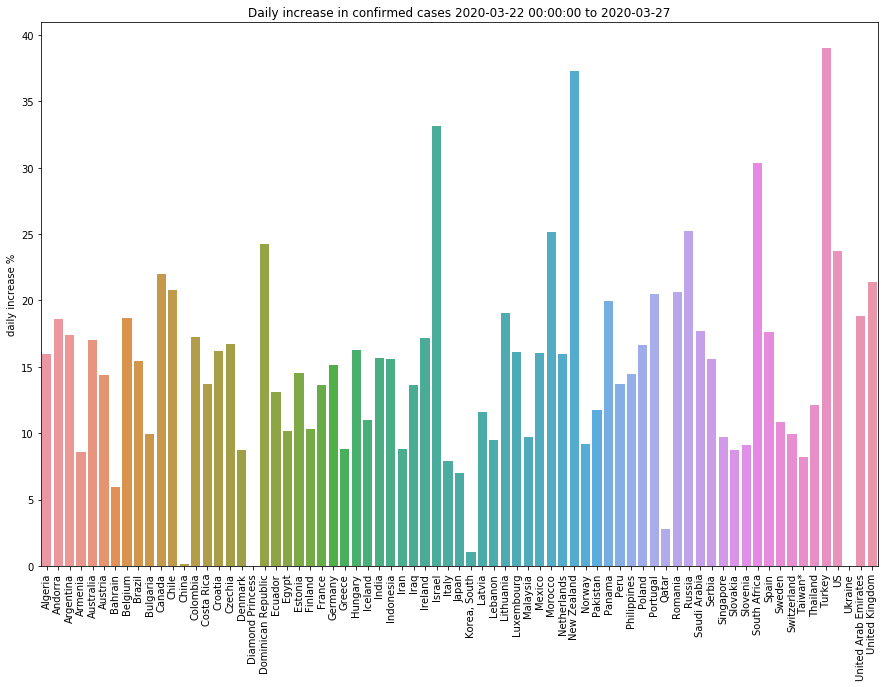

In [26]:
plt.subplots(figsize=(15,10))
sns.barplot(x=HighCountries,y=100*(10**allSlopes[:,today-1]-1))
#plt.ylim([0,.001])
plt.title('Daily increase in confirmed cases '+str(df.date.max()-pd.DateOffset(fitHistory))+' to '+str(df.date.max()))
plt.ylabel('daily increase %')
plt.xticks(rotation=90);

# Recovery

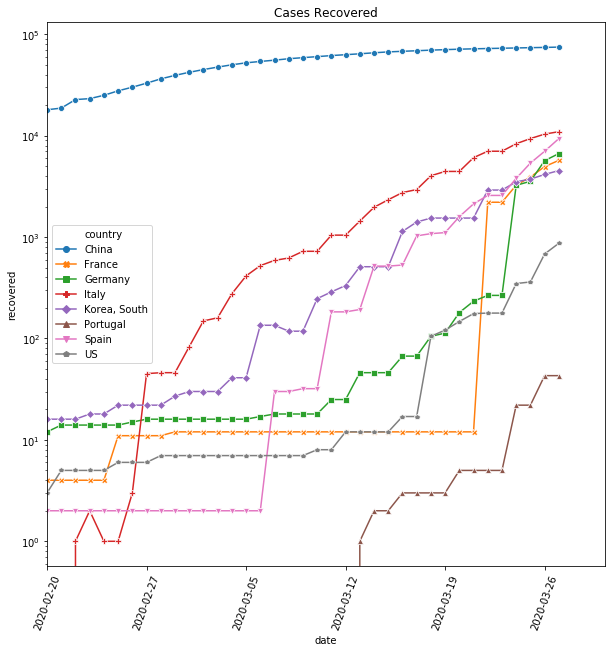

In [27]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='recovered',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Cases Recovered')
plt.xlim(left=plotStartDate);
plt.yscale('log')


# Ratio of recovered / total cases

### This ratio will eventually approach mortality, but note ~2-3 week delay from case report to recovery.

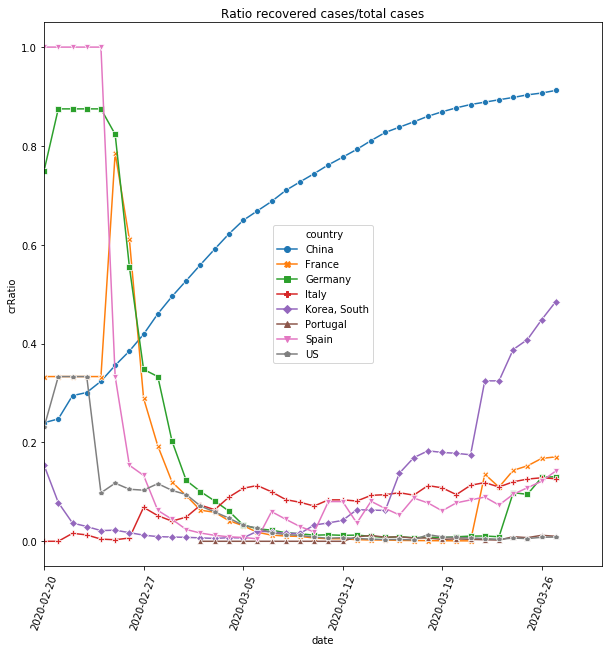

In [28]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='crRatio',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Ratio recovered cases/total cases')
plt.xlim(left=plotStartDate);

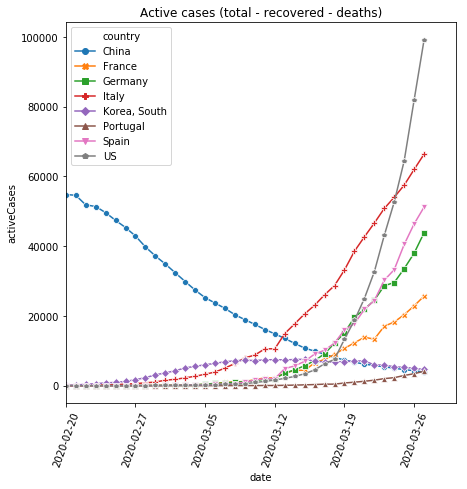

In [29]:
plt.subplots(figsize=(7,7))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='activeCases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Active cases (total - recovered - deaths)')
plt.xlim(left=plotStartDate);

# Compare Robert Koch Institute (RKI) data to John's Hopkins

In [61]:
dfGermany=df[df.country=='Germany']
dfGermany.date=pd.to_datetime(dfGermany.date)
tmp=df_rki.groupby('Meldedatum').sum().cumsum().reset_index()
tmp.Meldedatum=pd.to_datetime(tmp.Meldedatum)#+pd.DateOffset(2)
dfGermany=dfGermany.merge(tmp[['Meldedatum','AnzahlFall']],how='right',left_on='date',right_on='Meldedatum')
dfGermany.tail()

C:\Users\johannes\Miniconda3\envs\jlsocial\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases,Meldedatum,AnzahlFall
39,Germany,2020-03-23,29056,123,266,82667685.0,0.004233,0.000351,28667,0.009155,4183.0,2020-03-23,32028
40,Germany,2020-03-24,32986,157,3243,82667685.0,0.004760,0.000399,29586,0.098314,3930.0,2020-03-24,36596
41,Germany,2020-03-25,37323,206,3547,82667685.0,0.005519,0.000451,33570,0.095035,4337.0,2020-03-25,41823
42,Germany,2020-03-26,43938,267,5673,82667685.0,0.006077,0.000532,37998,0.129114,6615.0,2020-03-26,46599
43,Germany,2020-03-27,50871,342,6658,82667685.0,0.006723,0.000615,43871,0.130880,6933.0,2020-03-27,48549


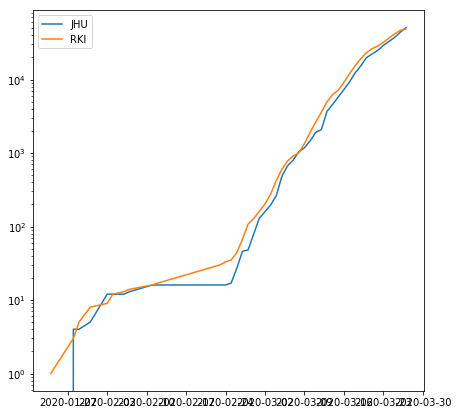

In [62]:
plt.subplots(figsize=(7,7))
plt.plot(dfGermany.date,dfGermany.cases,label='JHU')
plt.plot(dfGermany.date,dfGermany.AnzahlFall,label='RKI')
plt.yscale('log');
plt.legend();

In [63]:
df_rki.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall
0,3,Niedersachsen,LK Goslar,A60-A79,M,2,0,444297,2020-03-13,3153,28.03.2020 00:00,0,-9
1,3,Niedersachsen,LK Goslar,A60-A79,M,1,0,444298,2020-03-18,3153,28.03.2020 00:00,0,-9
2,3,Niedersachsen,LK Goslar,A60-A79,M,1,0,444299,2020-03-23,3153,28.03.2020 00:00,0,-9
3,3,Niedersachsen,LK Goslar,A60-A79,M,1,0,444300,2020-03-24,3153,28.03.2020 00:00,0,-9
4,3,Niedersachsen,LK Goslar,A60-A79,M,1,0,444301,2020-03-25,3153,28.03.2020 00:00,0,-9


# Cases and deaths by age group and gender

Text(0.5,1,'Faelle in Deutschland')

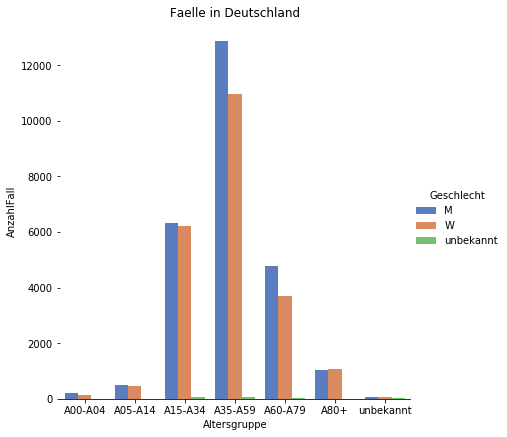

In [112]:
#fix,ax=plt.subplots(figsize=(10,10))

tmp=df_rki.groupby(['Geschlecht','Altersgruppe']).sum().reset_index()
g = sns.catplot(x="Altersgruppe", y="AnzahlFall", hue="Geschlecht", data=tmp,
                height=6, kind="bar", palette="muted")
g.despine(left=True);
plt.title('Faelle in Deutschland')

Text(0.5,1,'Todesfaelle in Deutschland')

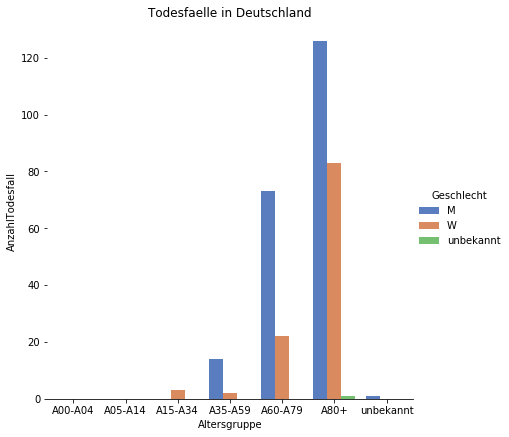

In [113]:
tmp=df_rki.groupby(['Geschlecht','Altersgruppe']).sum().reset_index()
g = sns.catplot(x="Altersgruppe", y="AnzahlTodesfall", hue="Geschlecht", data=tmp,
                height=6, kind="bar", palette="muted")
g.despine(left=True);
plt.title('Todesfaelle in Deutschland')

# Analyze states of Germany

In [68]:
tmp=df_rki.groupby(['Bundesland','Meldedatum']).sum().reset_index()
tmp['cases']=tmp.groupby(['Bundesland']).AnzahlFall.cumsum()
tmp.head()

,Bundesland,Meldedatum,IdBundesland,AnzahlFall,AnzahlTodesfall,ObjectId,IdLandkreis,NeuerFall,NeuerTodesfall,cases
0,Baden-Württemberg,2020-01-24,8,1,0,453886,8216,0,-9,1
1,Baden-Württemberg,2020-02-23,72,12,0,4083216,73788,0,-81,13
2,Baden-Württemberg,2020-02-24,16,2,0,911356,16853,0,-18,15
3,Baden-Württemberg,2020-02-25,16,2,0,908097,16533,0,-18,17
4,Baden-Württemberg,2020-02-26,40,5,0,2272067,41483,0,-45,22


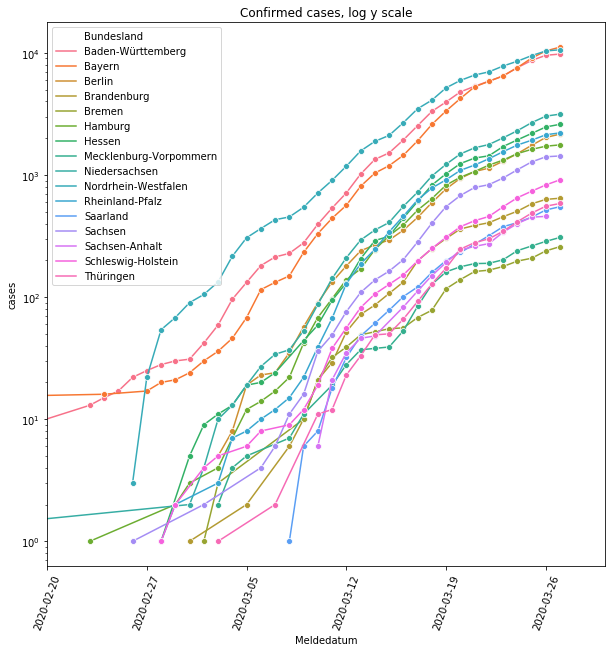

In [49]:
# Plot cases on log y scale
plt.subplots(figsize=(10,10))
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=tmp,
             x='Meldedatum',
             y='cases',
            hue='Bundesland',
              dashes=False,
              marker='o')
ax = g.axes
ax.set_yscale('log')
plt.title('Confirmed cases, log y scale')
plt.xlim(left=plotStartDate)
plt.xticks(rotation=70);

In [94]:
tmp=df_rki.groupby(['Bundesland','Meldedatum']).sum().reset_index()
tmp['cases']=tmp.groupby(['Bundesland']).AnzahlFall.cumsum()
tmp=tmp[['Bundesland','Meldedatum','cases']]
tmp=tmp.pivot_table(columns='Bundesland',index='Meldedatum',values='cases').unstack().reset_index()
tmp.columns=[tmp.columns[0],tmp.columns[1],'cases']
tmp.head()

,Bundesland,Meldedatum,cases
0,Baden-Württemberg,2020-01-24,1.0
1,Baden-Württemberg,2020-01-28,NaN
2,Baden-Württemberg,2020-01-29,NaN
3,Baden-Württemberg,2020-01-31,NaN
4,Baden-Württemberg,2020-02-03,NaN


C:\Users\johannes\Miniconda3\envs\jlsocial\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


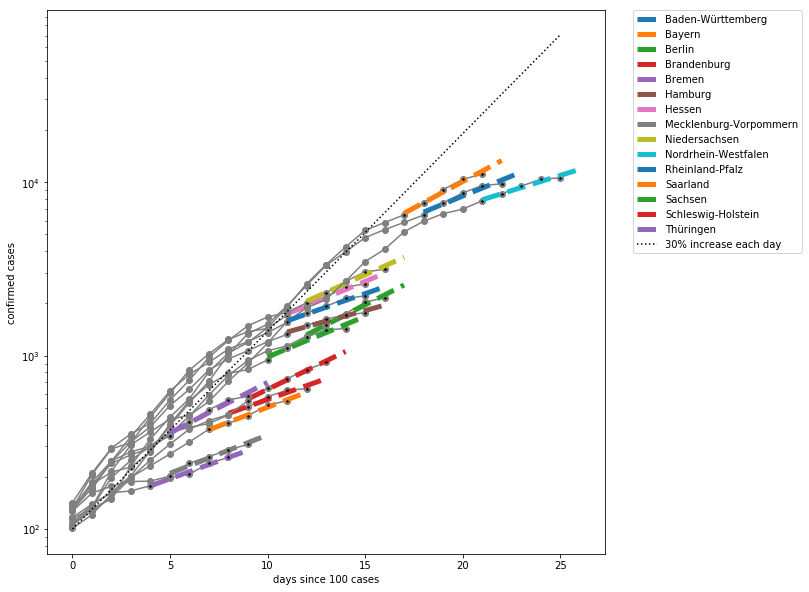

In [95]:
fitHistory=5 #days used for fit

fix,ax=plt.subplots(figsize=(10,10))

numStates=tmp.Bundesland.unique()

allSlopesStates=np.zeros((len(numStates),100))*np.nan

for i,c in enumerate(numStates):
    ix=tmp.Bundesland==c
    ts=tmp[ix].cases.values
    if ts[-1]>100:
        #ts=ts[ts>100]
        caseLen=ts.shape[0]
        inflect=np.argmax(ts>100)
        
        for j in range(ts.shape[0]-fitHistory-inflect):
            x=np.arange(fitHistory)
            y=np.log10(ts[j+inflect+1:j+fitHistory+inflect+1])

            s,itc,r,p,std=scipy.stats.linregress(x,y)
            allSlopesStates[i,j+inflect+1+offset]=s
        
        ax.plot(ts[inflect:],'o-',color='gray')
        t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
        tx=np.linspace(0,fitHistory,100)
        l=(10**itc)*(10**(s*tx))
        ax.plot(t,l,'--',label=c,lw=5)
        ax.plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend(ncol=1,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

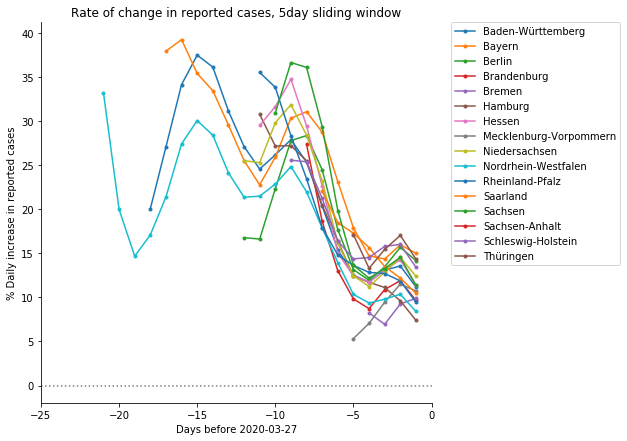

In [107]:
fix,ax=plt.subplots(figsize=(7,7))

today=np.where(np.nansum(allSlopesStates,axis=0)==0)[0][58]
xt=np.arange(allSlopesStates.shape[1])-today
for i,c in enumerate(numStates):
    ax.plot(xt,100*(10**allSlopesStates[i,:]-1),'.-',label=c);
    #ax.set_xlim([40,70]);
    
plt.legend()
plt.axhline(0,ls=':',color='gray')
plt.ylabel('% Daily increase in reported cases')
plt.xlabel('Days before '+ str(df.date.max()));
plt.title('Rate of change in reported cases, 5day sliding window')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([-25,0])
sns.despine()